In [3]:
# Concept Drift Detection (Custom Window-based) for IoMT IDS (XGBoost-based) - Mirroring Figure 16 style

import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

In [5]:
# Load dataset (assuming already structured like previous pipeline)
def load_dataset_from_structure(root_path):
    data = []
    for file in root_path.glob('*/*/*.csv'):
        df = pd.read_csv(file)
        category = file.parents[1].name
        attack = file.parent.name
        label_class = 'Benign' if category.upper() == 'BENIGN' else 'Attack'
        df['category'] = category
        df['attack'] = attack
        df['class'] = label_class
        data.append(df)
    return pd.concat(data, ignore_index=True)

# Path setup (edit as needed)
train_root = Path('../../../../Data/CICIoMT2024/train')
test_root = Path('../../../../Data/CICIoMT2024/test')

train_df = load_dataset_from_structure(train_root)
test_df = load_dataset_from_structure(test_root)

df = pd.concat([train_df, test_df], ignore_index=True)


In [7]:
# Preprocessing
X = df.drop(['class', 'category', 'attack'], axis=1, errors='ignore').select_dtypes(include=[np.number])
y = LabelEncoder().fit_transform(df['attack'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [9]:
# Train model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', tree_method='hist')
model.fit(X_train, y_train)


C:\Users\Admin\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:19:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [10]:
# Custom window-based drift detection (threshold method)
window_size = 100
threshold = 0.90
accuracies = []
drift_points = []

for i in range(window_size, len(X_test)):
    window_X = X_test[i-window_size:i]
    window_y = y_test[i-window_size:i]
    preds = model.predict(window_X)
    acc = accuracy_score(window_y, preds)
    accuracies.append(acc)
    if acc < threshold:
        drift_points.append(i)
        print(f"🔺 Simulated drift detected at index {i} due to accuracy drop: {acc:.3f}")


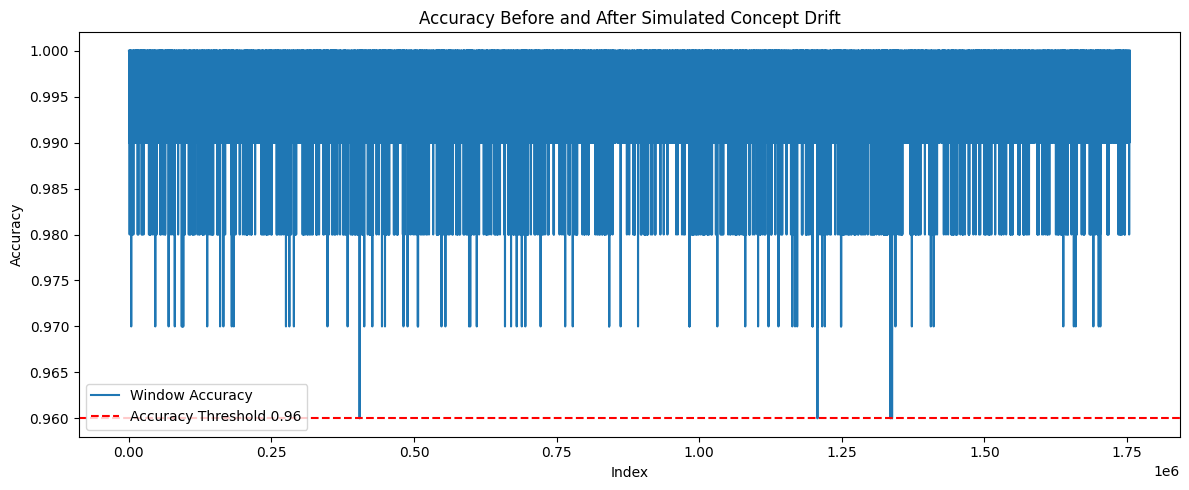

In [11]:
# Plotting like Figure 16
plt.figure(figsize=(12, 5))
plt.plot(range(window_size, len(X_test)), accuracies, label='Window Accuracy')
plt.axhline(0.96, color='red', linestyle='--', label='Accuracy Threshold 0.96')
for dp in drift_points:
    plt.axvline(x=dp, color='blue', linestyle=':', linewidth=1)

plt.title("Accuracy Before and After Simulated Concept Drift")
plt.xlabel("Index")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
# Evaluate accuracy before and after each drift segment
segments = [window_size] + drift_points + [len(X_test)]
for idx in range(len(segments) - 1):
    start, end = segments[idx], segments[idx + 1]
    seg_X = X_test[start:end]
    seg_y = y_test[start:end]
    seg_preds = model.predict(seg_X)
    seg_acc = accuracy_score(seg_y, seg_preds)
    print(f"✅ Accuracy on segment {idx+1} (index {start} to {end}): {seg_acc:.4f}")

✅ Accuracy on segment 1 (index 100 to 1755003): 0.9977
